# Building a WaveNet

In [1]:
# Imports
import torch
import torch.nn.functional as F

import random
from typing import Any

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset

DATA_DIR = "../data/indian_names.txt"

block_size = 8          # Context Length! How many characters to take to predict the next one

train_split = 0.8
dev_split = 0.1
test_split = 0.1

assert (train_split + dev_split + test_split) == 1.0, "Data Split ration does not add up to 1.0"

# Loading data
words = open(DATA_DIR, 'r').read().splitlines()
print(len(words), "words.")

# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']
chrs = sorted(chrs + special_characters)

# Takes some words and builds X and Y data out of it
def build_dataset(words, type = 'train'):
    
    X, Y = [], []

    for word in words:
        #print(''.join(word))
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Shape of {type} data is     X -> {X.shape}      Y ->  {Y.shape}")

    return X, Y

# Shuffling the data
random.seed(800)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Calling build
Xtrain, Ytrain = build_dataset(words[:n1], "train")
Xdev, Ydev = build_dataset(words[n1:n2], "dev")
Xtest, Ytest = build_dataset(words[n2:], "test")

6474 words.
Shape of train data is     X -> torch.Size([38221, 8])      Y ->  torch.Size([38221])
Shape of dev data is     X -> torch.Size([4691, 8])      Y ->  torch.Size([4691])
Shape of test data is     X -> torch.Size([4705, 8])      Y ->  torch.Size([4705])


In [3]:
from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias = True) -> None:
        self.weights = torch.randn(fan_in, fan_out) / fan_in**0.5
        self.bias = None
        self.training = True
        if bias:
            self.bias = torch.zeros(fan_out)

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):

        if self.bias is not None:
            return [self.weights] + [self.bias]
        else:
            return [self.weights]
        
# ________________________________________________________________________________________________________________
        
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Batch Norm weights
        self.aplha = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffer weights
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        # Find mean and var
        # If input is 2d or 3d then mean across which dims
        if x.ndim == 2:
            dim = 0
        else:
            dim = (0, 1)
        if self.training:
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # Calculate output
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = (self.aplha * xhat) + self.beta
        # Update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum * xmean)
            self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)
        # Return the output
        return self.out
    
    def parameters(self):
        return [self.aplha, self.beta]

# _________________________________________________________________________________________________________
    
class Tanh:

    def __init__(self) -> None:
        self.training = True

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
# ________________________________________________________________________________________________________

class Embedding:

    def __init__(self, num_chrs, embid_size) -> None:
        self.training = True
        self.weights = torch.randn(num_chrs, embid_size)
        
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        ix = args[0]
        self.out = self.weights[ix]
        return self.out
    
    def parameters(self):
        return [self.weights]
    
# _______________________________________________________________________________________________________________

class MyFlatten:

    def __init__(self, grouping) -> None:
        self.training = True
        self.grouping = grouping

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        emb = args[0]
        B, T, C = emb.shape
        self.out = emb.view(B, T//2, C*self.grouping)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out
    
    def parameters(self):
        return []
    
# ________________________________________________________________________________________________________________

class Sequential:

    def __init__(self, layers : list) -> None:
        self.layers = layers

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [66]:
# Visualize activations and gradients
def visualize_act_or_grad(layers, act_grad = "act"):

    plt.figure(figsize = (20, 4))
    legends = []

    for i, layer in enumerate(layers[0:-1]):
        if isinstance(layer, Tanh):
            try:
                if act_grad == 'act':
                    t = layer.out
                elif act_grad == 'grad':
                    t = layer.out.grad
            except Exception as e:
                print(f"Having act_grad as {act_grad} is not allowed. {e}")
            print(f"Layer {i}   |   Type {layer.__class__.__name__}    |   Mean {t.mean()}  |   Std {t.std()}   |   Saturation {(t.abs() > 0.97).float().mean()*100}%")
            hy, hx = torch.histogram(t, density = True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"Layer {i}")

    plt.legend(legends)
    if act_grad == 'act':
        plt.title("Activations Distribution")
    else:
        plt.title("Gradient Distribution")

    plt.show()

# Sample from the model
def sample_names(model, num_names, block_size):

    names = []

    for layer in model.layers:
        layer.training = False

    for i in range(num_names):
        name = ""
        context = [0] * block_size

        while True:
            # forward pass
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim = 1)
            # sample from this dist
            ix = torch.multinomial(probs, num_samples = 1, replacement = True).item()
            context = context[1:] + [ix]
            # break and save because end of word
            if itos[ix] == '.':
                names.append(name)
                break
            # store characters
            name = name + itos[ix]
    return names

In [43]:
# Hyperparaeters
block_size = 8          # Context Length! How many characters to take to predict the next one
embid_size = 20          # How many dimension in the embedding space
batch_size = 256
num_hidden_1 = 512
num_hidden_2 = 256        # Number of neurons in the hidden layer
num_outputs = 27
# lr = 0.05
loss_track = []
epochs = 7000

In [45]:
# Building Network

torch.manual_seed(800)

# Initializing all the layers
model = Sequential([  Embedding(len(chrs), embid_size),
            MyFlatten(2),
            Linear(   embid_size * 2, num_hidden_1), BatchNorm1d(num_hidden_1), Tanh(),
            MyFlatten(2),
            Linear(   num_hidden_1 * 2, num_hidden_2), BatchNorm1d(num_hidden_2), Tanh(),
            MyFlatten(2),
            Linear(   num_hidden_2 * 2, num_outputs)])

# Apply gains to layers
with torch.no_grad():
    # Low confidence softmax
    model.layers[-1].weights *= 0.1

parameters = model.parameters()
print(f"Total parameters to train --> {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total parameters to train --> 299319


In [46]:
# Training Loop

for epoch in range(epochs):

    # Batch creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb = Xtrain[ix]
    Yb = Ytrain[ix]

    # Training / Testing check
    for layer in model.layers:
        layer.training = True

    # Forward Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # # Backward Pass
    # for layer in model.layers:
    #     layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.05 if epoch < 6000 else 0.001
    for p in parameters:
        p.data -= lr * p.grad

    # Statistics
    if epoch % 500 == 0:
        print(f'Epoch --> {epoch:4d} / {epochs:4d}      loss --> {loss.item()}')

    # Accumulate
    loss_track.append(loss.log10().item())

    #break

Epoch -->    0 / 7000      loss --> 3.290771245956421
Epoch -->  500 / 7000      loss --> 2.1826789379119873
Epoch --> 1000 / 7000      loss --> 1.9904857873916626
Epoch --> 1500 / 7000      loss --> 1.9590576887130737
Epoch --> 2000 / 7000      loss --> 1.8350387811660767
Epoch --> 2500 / 7000      loss --> 1.8331186771392822
Epoch --> 3000 / 7000      loss --> 1.857310175895691
Epoch --> 3500 / 7000      loss --> 1.9653218984603882
Epoch --> 4000 / 7000      loss --> 1.7044317722320557
Epoch --> 4500 / 7000      loss --> 1.8444545269012451
Epoch --> 5000 / 7000      loss --> 1.749500036239624
Epoch --> 5500 / 7000      loss --> 1.858851671218872
Epoch --> 6000 / 7000      loss --> 1.6696717739105225
Epoch --> 6500 / 7000      loss --> 1.6468197107315063


Layer 4   |   Type Tanh    |   Mean -2.640099046402611e-05  |   Std 0.5403362512588501   |   Saturation 6.8920135498046875%
Layer 8   |   Type Tanh    |   Mean -0.00012484891340136528  |   Std 0.5875553488731384   |   Saturation 8.0902099609375%


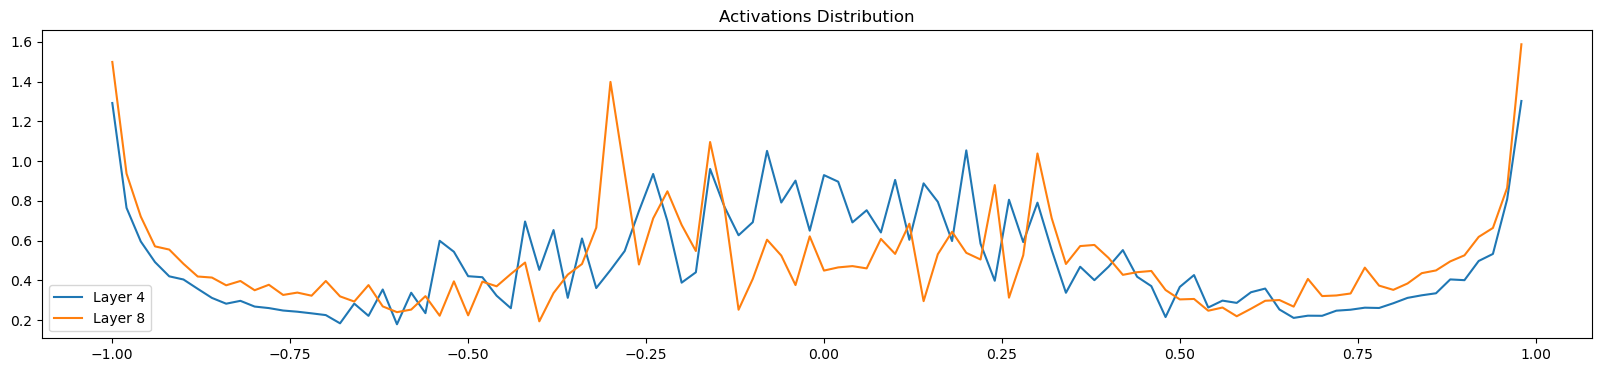

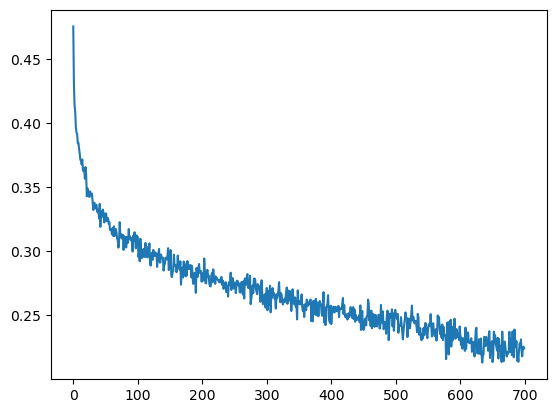

In [47]:
visualize_act_or_grad(model.layers, 'act')
#visualize_act_or_grad(model.layers, 'grad')
# Plotting the loss vs epochs

plt.plot(torch.tensor(loss_track).view(-1, 10).mean(1))
# plt.plot(loss_track)

In [49]:
# Testing loss on a dataset
@torch.no_grad()
def split_loss(split):
    xs, ys = {
        'train' : (Xtrain, Ytrain),
        'dev' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]

    for layer in model.layers:
        layer.training = False

    # Forward Pass
    logits = model(xs)
    loss = F.cross_entropy(logits, ys)

    print(f"{split} loss        ->      {loss.item()}")

split_loss('train')
split_loss('dev')

train loss        ->      1.6705427169799805
dev loss        ->      2.0053324699401855


# Performances

1) Switched to WaveNet and trained for 20,000 epochs with NO learning rate decay
- train loss        ->      1.4868768453598022
- dev loss        ->      2.2091715335845947

2) Switched to WaveNet and trained for 20,000 epochs WITH learning rate decay
- train loss        ->      1.5512913465499878
- dev loss        ->      2.057615041732788

3) Changed the num hidden neurons from 512, 512 to 512, 256, changed embid_size to 20
- train loss        ->      1.4909939765930176
- dev loss        ->      2.0743000507354736

4) Just reducing the epochs to 10,000
- train loss        ->      1.6352226734161377
- dev loss        ->      2.0087525844573975

5) Recuing epochs to 7000 and >6000 lr = 0.001
- train loss        ->      1.6705427169799805
- dev loss        ->      2.0053324699401855

In [69]:
sample_names(model, 25, block_size)

['gulaksha',
 'anand',
 'rabhoom',
 'budam',
 'hariri',
 'ratni',
 'sanita',
 'tynyumudra',
 'chhabana',
 'kshora',
 'deeptya',
 'parjal',
 'badasibank',
 'subrish',
 'narxat',
 'faron',
 'saku',
 'rajni',
 'vani',
 'riya',
 'vikaramjeet',
 'chottaupal',
 'babu',
 'pren',
 'mogsaya']